In [20]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')



In [21]:
df = pd.read_excel('METABRIC_Data.xlsx', sheet_name='Sheet1')


In [22]:
# Clean column names (use of underscore instead of spaces)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [23]:
print(df.columns)

Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc',
       'er_status', 'neoplasm_histologic_grade',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index', 'oncotree_code',
       'overall_survival_(months)', 'overall_survival_status', 'pr_status',
       'radio_therapy', 'relapse_free_status_(months)', 'relapse_free_status',
       'sex', '3-gene_classifier_subtype', 'tumor_size', 'tumor_stage',
       'patient's_vital_status'],
      dtype='object')


In [24]:
# Handle Null values
df = df.dropna(subset=['overall_survival_(months)', 'overall_survival_status'])

# Create 10-year mortality target
df['10_year_mortality'] = np.where(
    (df['overall_survival_(months)'] <= 120) & 
    (df['overall_survival_status'] == 'Deceased'), 1, 0)

df.loc[(df['overall_survival_(months)'] < 120) & 
       (df['overall_survival_status'] == 'Living'), '10_year_mortality'] = np.nan
df = df.dropna(subset=['10_year_mortality'])


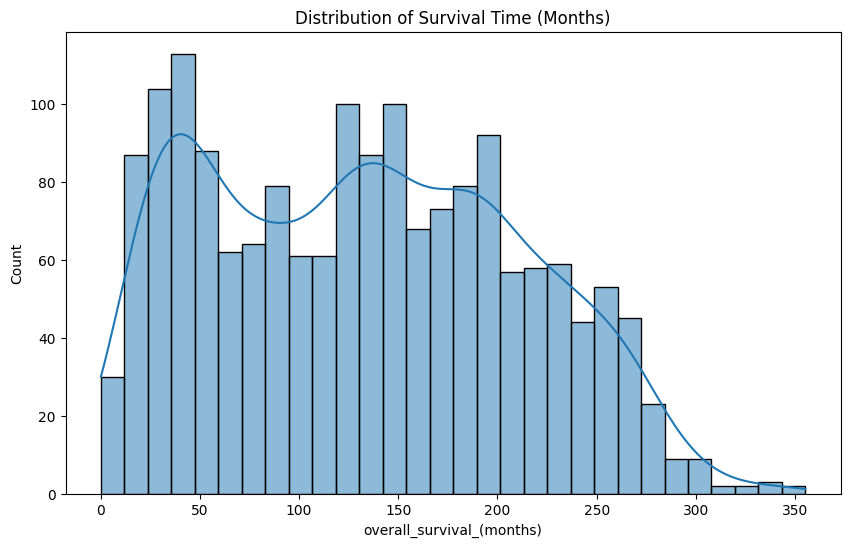

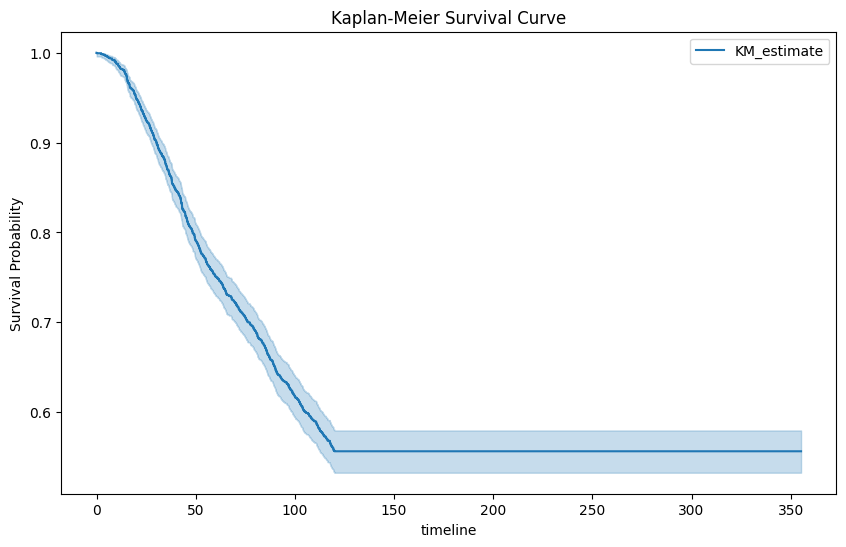

In [25]:
# Over all survival distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['overall_survival_(months)'], bins=30, kde=True)
plt.title('Distribution of Survival Time (Months)')
plt.show()

# Kaplan-Meier analysis
kmf = KaplanMeierFitter()
kmf.fit(df['overall_survival_(months)'], event_observed=df['10_year_mortality'])

plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.ylabel('Survival Probability')
plt.show()

In [26]:
# Select relevant features
features = ['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type_detailed',
            'er_status', 'her2_status', 'tumor_stage', 'tumor_size', 
            'neoplasm_histologic_grade', 'lymph_nodes_examined_positive',
            'nottingham_prognostic_index', 'chemotherapy', 'hormone_therapy',
            'radio_therapy']

# Pipepline | Preprocessing
# Preprocessing pipeline
numeric_features = ['age_at_diagnosis', 'tumor_size', 
                    'lymph_nodes_examined_positive', 'nottingham_prognostic_index']
categorical_features = ['type_of_breast_surgery', 'er_status', 'her2_status',
                        'neoplasm_histologic_grade', 'chemotherapy', 
                        'hormone_therapy', 'radio_therapy']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])


In [27]:
# Fill empty values
for col in numeric_features:
    df[col] = df[col].fillna(df[col].mean()) 

for col in categorical_features:
    df[col] = df[col].fillna(df[col].mode()[0])

In [28]:
# Prepare data
X = df[features]
y = df['10_year_mortality']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_processed, y_train)

# Model pipeline (Uses anyone of the models)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000), # preferably this
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True)
}

# Model training and evaluation
results = {}
for name, model in models.items():
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]

    results[name] = {
        'roc_auc': roc_auc_score(y_test, y_proba),
        'classification_report': classification_report(y_test, y_pred)
    }

<Figure size 1000x600 with 0 Axes>

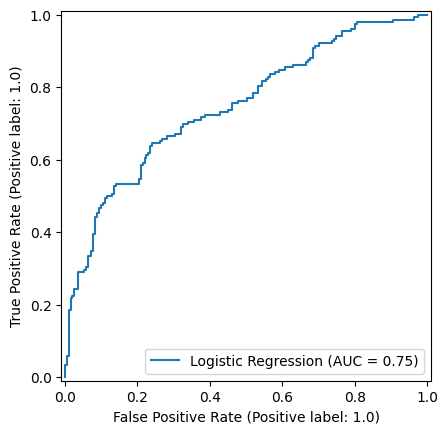

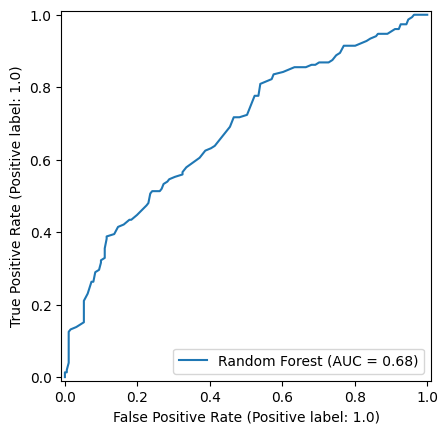

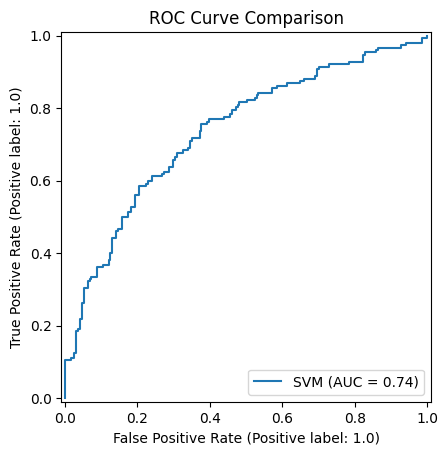

Model: Logistic Regression
ROC-AUC: 0.746
              precision    recall  f1-score   support

         0.0       0.73      0.72      0.72       191
         1.0       0.65      0.66      0.66       152

    accuracy                           0.69       343
   macro avg       0.69      0.69      0.69       343
weighted avg       0.69      0.69      0.69       343



Model: Random Forest
ROC-AUC: 0.683
              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67       191
         1.0       0.58      0.56      0.57       152

    accuracy                           0.62       343
   macro avg       0.62      0.62      0.62       343
weighted avg       0.62      0.62      0.62       343



Model: SVM
ROC-AUC: 0.737
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71       191
         1.0       0.64      0.64      0.64       152

    accuracy                           0.68       343
   macro avg       0

In [29]:
# ROC curve
plt.figure(figsize=(10, 6))
for name, model in models.items():
    RocCurveDisplay.from_estimator(
        model, 
        preprocessor.transform(X_test), 
        y_test, 
        name=name
    )
plt.title('ROC Curve Comparison')
plt.show()

# Performance metrics for all three models
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"ROC-AUC: {metrics['roc_auc']:.3f}")
    print(metrics['classification_report'])
    print("\n" + "="*50 + "\n")

In [30]:
# Accuracy Report
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.68
AUC-ROC: 0.74

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71       191
         1.0       0.64      0.64      0.64       152

    accuracy                           0.68       343
   macro avg       0.68      0.68      0.68       343
weighted avg       0.68      0.68      0.68       343



Text(0, 0.5, 'True Labels')

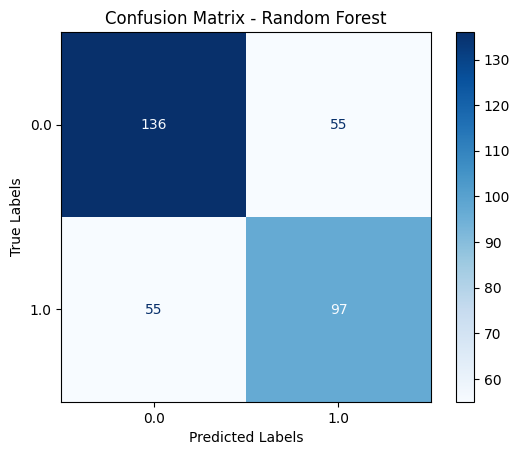

In [31]:
# Confusion Matrix 
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_processed, y_train)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix - Random Forest')
disp.ax_.set_xlabel('Predicted Labels')
disp.ax_.set_ylabel('True Labels')

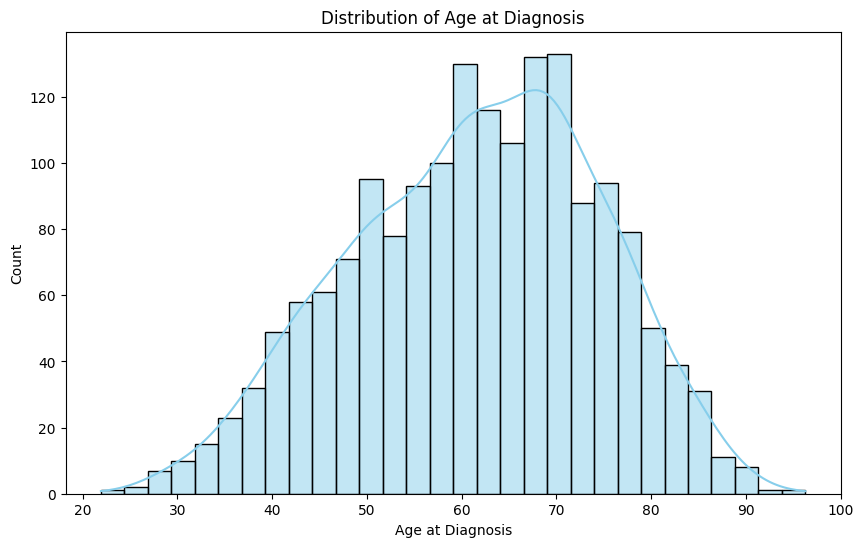

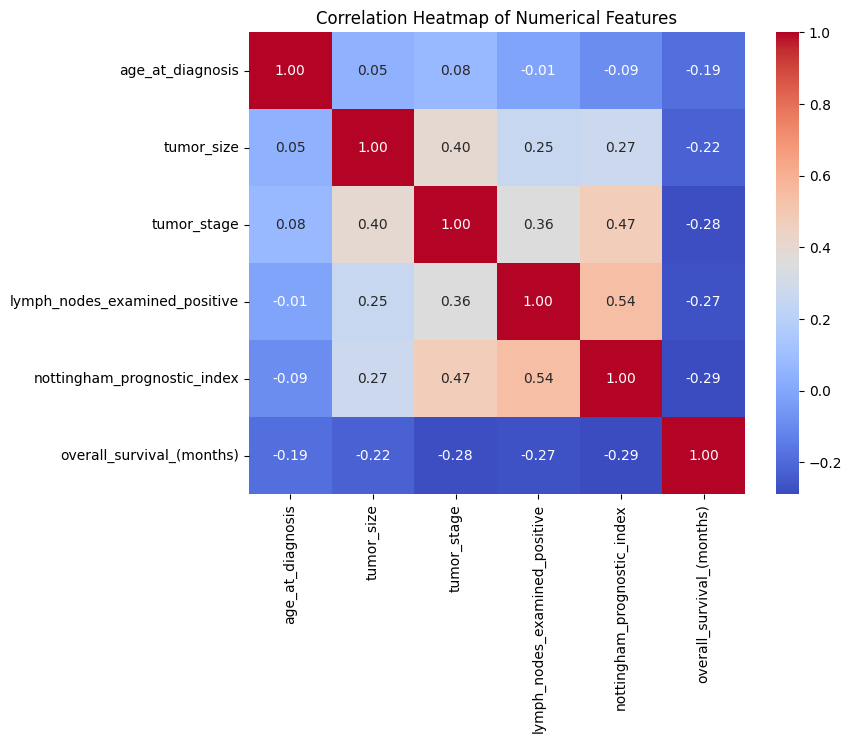

In [32]:
eda_columns = ['age_at_diagnosis', 'tumor_size', 'tumor_stage', 
               'lymph_nodes_examined_positive', 'nottingham_prognostic_index', 
               'overall_survival_(months)']

for col in eda_columns:
    df[col] = df[col].fillna(df[col].mean())

# Plot distribution for "Age at Diagnosis"
plt.figure(figsize=(10, 6))
sns.histplot(df['age_at_diagnosis'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Age at Diagnosis')
plt.xlabel('Age at Diagnosis')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
correlation_matrix = df[eda_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()